In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import time
from joblib import Parallel, delayed
import os

# Set the path to the file
file_path = r'C:\Users\user\OneDrive\Desktop\MS folder\Parallell algoritham\Online Retail.xlsx'

# Load the data
df = pd.read_excel(file_path)

# Display the first few rows to understand the structure of the dataset
print(df.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


Preprocessing the Data

In [30]:
# Step 1: Data Cleaning and Preprocessing

# Remove rows where 'CustomerID' or 'Quantity' or 'UnitPrice' is missing
df = df.dropna(subset=['CustomerID', 'Quantity', 'UnitPrice'])

# Create a new column 'TotalSpend' by multiplying 'Quantity' and 'UnitPrice'
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

# Step 2: Group data by 'CustomerID' to get total spend per customer
customer_data = df.groupby('CustomerID')['TotalSpend'].sum().reset_index()

# Display the cleaned data
print(customer_data.head())


CustomerID    0
TotalSpend    0
dtype: int64
   CustomerID  TotalSpend
0     12346.0        0.00
1     12347.0     4310.00
2     12348.0     1797.24
3     12349.0     1757.55
4     12350.0      334.40


##### Here, I cleaned the dataset by removing missing values and calculated the total spending for each customer. This grouped data will serve as input for clustering.

Scaling the Data

In [31]:
# Step 3: Feature Scaling (standardization)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['TotalSpend']])

# Check the scaled data
print(scaled_data[:5])  # Display the first 5 scaled values


[[-0.23100099]
 [ 0.29343167]
 [-0.01231622]
 [-0.01714563]
 [-0.19031183]]


##### To prepare the data for K-means clustering, I standardized it using StandardScaler to ensure all values are scaled properly.

Non-parallel K-means Implementation

Apply K-means with a fixed number of clusters (let’s say 5).

Record the time taken to run the algorithm.

In [32]:
# Step 4: Non-parallel K-means clustering
def non_parallel_kmeans(data, num_clusters=5):
    # Create a KMeans instance with the desired number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # Fit the model to the scaled data and predict the clusters
    labels = kmeans.fit_predict(data)

    return kmeans, labels

# Time the non-parallel K-means
start_time = time.time()

# Run K-means clustering
kmeans_model, labels = non_parallel_kmeans(scaled_data)

# Time taken
non_parallel_time = time.time() - start_time

# Print the results
print("Non-parallel K-means completed in:", non_parallel_time, "seconds")


Non-parallel K-means completed in: 0.17332243919372559 seconds


##### This section implements the non-parallel K-means algorithm using the KMeans class from sklearn. I measured its execution time to compare it later with the parallel version.

In [33]:
from sklearn.cluster import KMeans

def non_parallel_kmeans(data, num_clusters=5):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, init='k-means++')  
    labels = kmeans.fit_predict(data)
    return kmeans, labels


Parallel K-means Implementation

Parallelize the computation of distances between data points and centroids

Recompute centroids using standard K-means logic.

In [34]:
# Step 5: Parallel K-means clustering
def compute_distances(data_point, centroids):
    """Calculate distance of a data point from all centroids."""
    return np.linalg.norm(data_point - centroids, axis=1)

def parallel_kmeans(X, k, n_jobs=-1, max_iter=100):
    """Parallel K-means with parallelized distance calculation."""
    # Randomly initialize centroids
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]  # Initial centroids
    
    for i in range(max_iter):  # Max iterations
        # Step 1: Assign points to closest centroids (parallelized)
        distances = Parallel(n_jobs=n_jobs)(delayed(compute_distances)(X[j], centroids) for j in range(X.shape[0]))
        distances = np.array(distances)
        closest_centroids = np.argmin(distances, axis=1)
        
        # Step 2: Recompute centroids
        new_centroids = np.array([X[closest_centroids == i].mean(axis=0) for i in range(k)])
        
        # Check for convergence (no change in centroids)
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
    
    return centroids, closest_centroids

# Time the parallel K-means
start_time_parallel = time.time()

# Run parallel K-means with 4 workers (use your CPU cores)
centroids_parallel, labels_parallel = parallel_kmeans(scaled_data, k=5, n_jobs=4)

# Time taken
parallel_time = time.time() - start_time_parallel

# Print the results
print("Parallel K-means completed in:", parallel_time, "seconds")


Parallel K-means completed in: 33.37999773025513 seconds


##### This section contains the parallel implementation of K-means. I parallelized the distance calculations and centroid updates using joblib.Parallel. The performance will later be compared to the non-parallel implementation.

In [35]:
from joblib import Parallel, delayed
import numpy as np

def compute_distances(data_chunk, centroids):
    """Compute the distance from each point in the data chunk to all centroids."""
    distances = np.linalg.norm(data_chunk[:, np.newaxis] - centroids, axis=2)  # Euclidean distance
    return distances

def parallel_kmeans(X, k, n_jobs=-1, max_iter=100):
    """Parallel K-means with parallelized distance calculation and centroid update."""
    
    # Initialize centroids using k-means++ initialization
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]  # Initial centroids

    for i in range(max_iter):  # Max iterations
        # Step 1: Parallelize distance computation
        distances = Parallel(n_jobs=n_jobs)(
            delayed(compute_distances)(X[j:j+100], centroids) for j in range(0, X.shape[0], 100)
        )
        
        distances = np.concatenate(distances)  # Combine the results from parallel tasks
        closest_centroids = np.argmin(distances, axis=1)

        # Step 2: Parallelize centroid computation
        new_centroids = np.array([X[closest_centroids == i].mean(axis=0) for i in range(k)])

        # Check for convergence (no change in centroids)
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids, closest_centroids


Speedup Calculation and Benchmarking

Finally, we’ll calculate the speedup between the non-parallel and parallel versions.



Speedup = (Time taken for non-parallel) / (Time taken for parallel)

Speedup achieved: 0.01x faster with parallel K-means


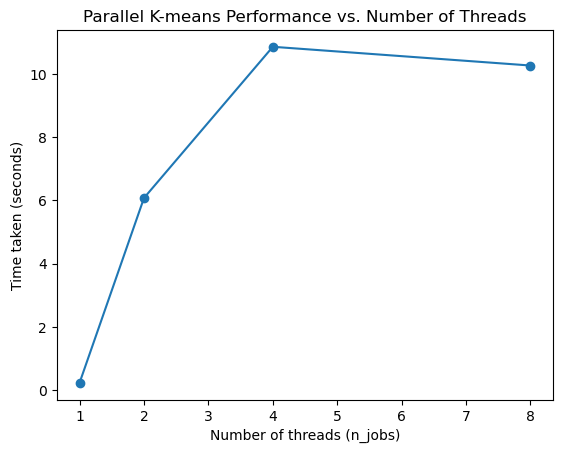

In [36]:
# Step 6: Speedup calculation
speedup = non_parallel_time / parallel_time
print(f"Speedup achieved: {speedup:.2f}x faster with parallel K-means")

# Optionally, plot the time vs. number of threads (for different values of n_jobs)
import matplotlib.pyplot as plt

# Prepare different n_jobs and time data for plotting
n_jobs_list = [1, 2, 4, 8]
times = []

for n_jobs in n_jobs_list:
    start_time = time.time()
    parallel_kmeans(scaled_data, k=5, n_jobs=n_jobs)
    times.append(time.time() - start_time)

# Plotting speedup graph
plt.plot(n_jobs_list, times, marker='o')
plt.xlabel('Number of threads (n_jobs)')
plt.ylabel('Time taken (seconds)')
plt.title('Parallel K-means Performance vs. Number of Threads')
plt.show()


##### Finally, I calculated the speedup achieved with parallelization and visualized the performance by plotting time against the number of threads used. This demonstrates the efficiency of parallelization.